In [52]:
import numpy as np
from tools import *
from scipy import signal
import seaborn as sns; sns.set_theme()
sns.set(rc={'figure.figsize':(18,8)})
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# def nan_argsort(a):
#     temp = a.copy()
#     temp[np.isnan(a)] = -np.inf
#     return temp.argsort()


# def do_siavash(XsereisTotal, N, shift=1, norm=1):

#     X = scipy.linalg.hankel(XsereisTotal)[: N + shift, : -N - shift + 1]

#     X0 = X[:-shift]
#     Xp = X[shift:]
#     # print(X0)
#     # print(Xp)
#     X0Xp = X0 @ Xp.T / X0.shape[1]
#     X0X0 = X0 @ X0.T / X0.shape[1]

#     GEV_sol = scipy.linalg.eig(X0Xp, X0X0)
#     evals = np.real_if_close(GEV_sol[0])
#     evecs = np.real_if_close(GEV_sol[1])
#     sort_ord = nan_argsort(np.real(evals))[::-1]
#     sign = np.sign(np.real(evecs[-1, sort_ord[0]]))
#     evec = []

#     for i, el in enumerate(evecs[:, sort_ord[0]]):
#         evec.append(np.real(sign * el))

#     evec = np.array(evec)

#     X = scipy.linalg.hankel(XsereisTotal)[:N,:-N+1]
#     print(X.shape, evec.shape)
#     proj_series = evec @ X

#     proj_series = proj_series / proj_series[0] * norm
#     return proj_series, evec


def cross_corr(x,y):
    corr = signal.correlate(x, y)
    lags = signal.correlation_lags(len(x), len(y))
    return lags, corr


def max_eig_project(sig, N, shift=1, norm=1):

    # build Hankels for X, X_0 and X_+
    X = build_hankel(sig, N)
    X0 = X[:, :-shift]
    Xp = X[:, shift:]

    X0Xp = X0 @ Xp.T #/ X0.shape[1]
    X0X0 = X0 @ X0.T #/ X0.shape[1]

    # solve eigenvalue problem
    evals, evecs = scipy.linalg.eig(X0Xp, X0X0, overwrite_a=True, overwrite_b=True)

    # get all real parts
    evals = np.real(np.real_if_close(evals))
    evecs = np.real(np.real_if_close(evecs))

    # get largest eigenvector
    largest_evec = evecs[:, np.nanargmax(evals)]

    # multiple by sign of last component??
    largest_evec  *= np.sign(largest_evec[-1])

    # project original series onto largest_evec
    proj_series = largest_evec @ X

    return proj_series, largest_evec


    

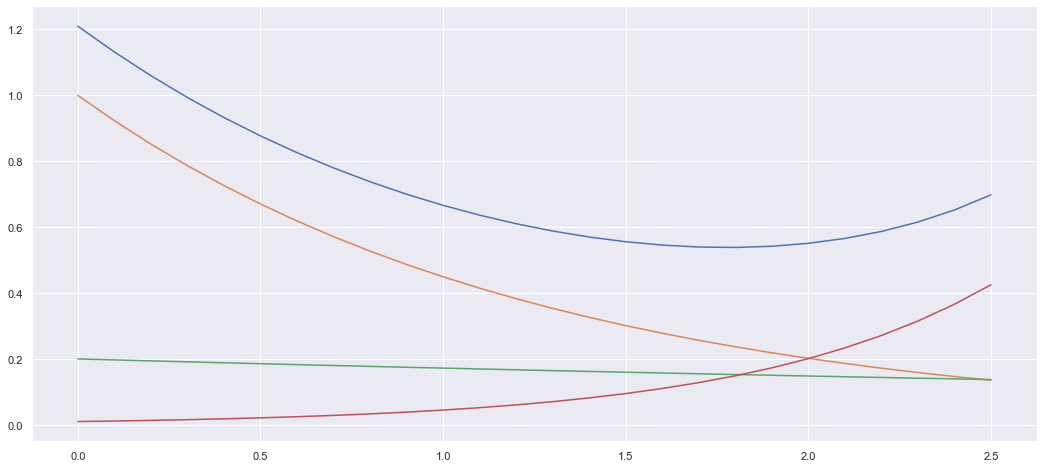

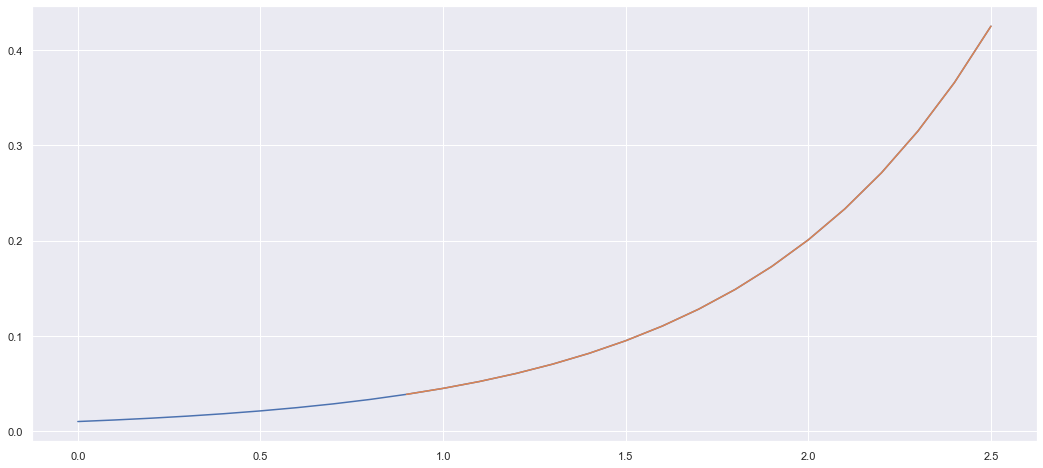

In [54]:
noise = 0.000001
N = 10


Exps = np.sort(np.array([1.5, -0.15, -0.8]))

N_max = 10
Ns = np.arange(3, N_max + 1, 3)
num_runs = 20
T = 2 * N_max
shifts = np.arange(1, 11, 3)
shift_max = max(shifts)

time = np.arange(0, 2.55, 0.1)
Inits = np.array([0.01, 0.2, 1])[::-1] #* (1 + 0 * 0.1 * np.random.randn(3))
Xseries = np.exp(time.reshape(-1, 1) * Exps.reshape(1, -1)) * Inits.reshape(
    1, -1
)

XseriesNoisy = Xseries * (1 + noise * np.random.randn(*Xseries.shape))
XsereisTotal = XseriesNoisy.sum(1)

plt.plot(time, XsereisTotal);
plt.plot(time, Xseries);
plt.show()

proj_series, evec = max_eig_project(XsereisTotal, N, shift=1)

X_target = XseriesNoisy[:, -1]

scalar = 1 / Xseries[N - 1, -1] *  proj_series[0]
scalar = 1/ np.mean(proj_series / X_target[len(X_target)-len(proj_series):])

plt.plot(time, X_target)
plt.plot(time[len(time)-len(proj_series):], proj_series*scalar)
plt.show()

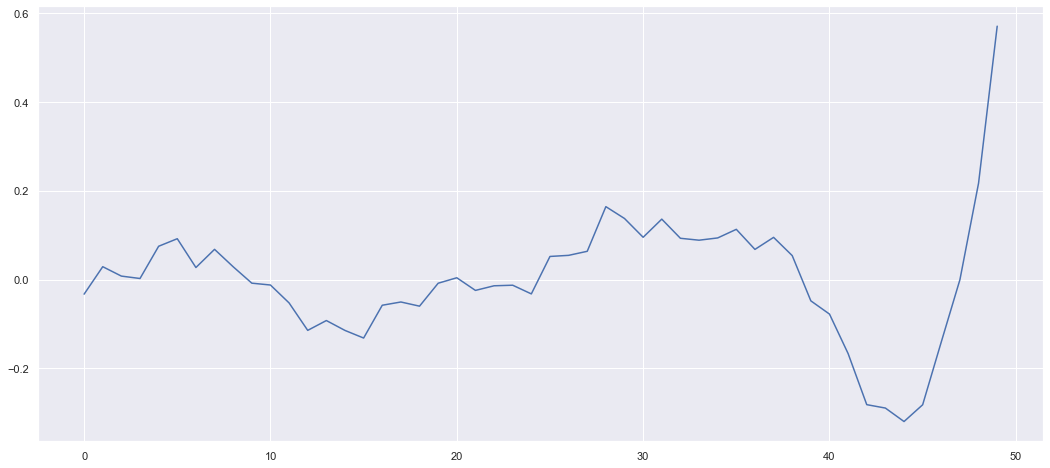

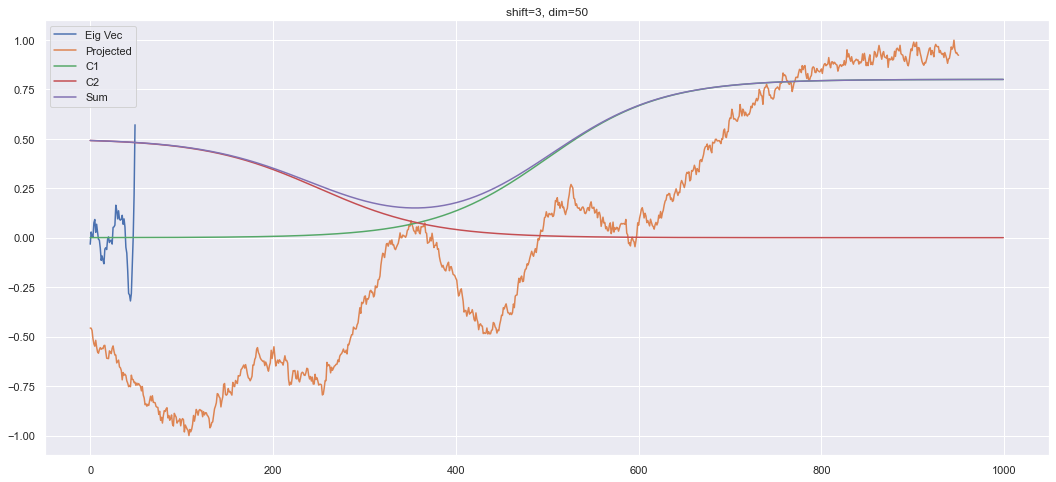

In [55]:
N = 1000
noise = 0.000001
dim = 50
shift = 10
L  = N-dim-shift
center = False

shifts = [3]
dims = np.linspace(50,500,1, dtype=int)

ys = []
for shift in shifts:
    for dim in dims:
        x = np.linspace(-8,8,N)
        sig1 = tanh(x, a=0.8, lam=1)
        sig2 =  tanh(x, a=0.5, lam=1, center=-4)[::-1]


        sig = sig1 +sig2 + noise * np.random.normal(size=N, scale=1)



        proj_series, evec = max_eig_project(sig, dim, shift=shift, norm=sig2[-1])
    
        plt.plot(evec); plt.show()
        
        proj_series = normalize(proj_series)
        plt.plot(evec); plt.plot(proj_series); plt.plot(sig1); plt.plot(sig2); plt.plot(sig);
        plt.legend(['Eig Vec', 'Projected', 'C1', 'C2', 'Sum' ])
        plt.title(f'shift={shift}, dim={dim}')
        plt.show()


        y = np.convolve(sig, evec, mode='valid')
        ys.append(y)


In [56]:
def build_signal_grid(x, num, noise=0, a=[1,1], lam=[1,1], return_basis=False, center=False):
    final_sig = np.zeros_like(x)
    basis = []
    for i in range(num):
        c = random.choice(x)
        sgn = rand_sgn()
        sig = tanh(x, a=rand_float(a[0],a[1]), lam=rand_float(lam[0],lam[1]), center=c)[::sgn]
        final_sig += sig
        if return_basis:
            basis.append(sig)
    final_sig += noise * np.random.normal(size=len(x), scale=1)

    if center:
        final_sig -= np.mean(final_sig)

    if return_basis:
        return final_sig, basis

    return final_sig

# time window shifted
def stride_eig(sig, window, dim, shift=1, stride=1, return_eigs=False):

    N = len(sig)
    y = np.zeros(N-window)

    eigs = []
    for i in range(0, N-window, stride):

        sigwin = sig[i:i+window]
        proj_series, evec = max_eig_project(sigwin, dim, shift=shift)
        y[i:i+stride] = evec @ sigwin[:dim]
        if return_eigs:
            eigs.append(evec)

    if return_eigs:
        return y, np.array(eigs)
    return y


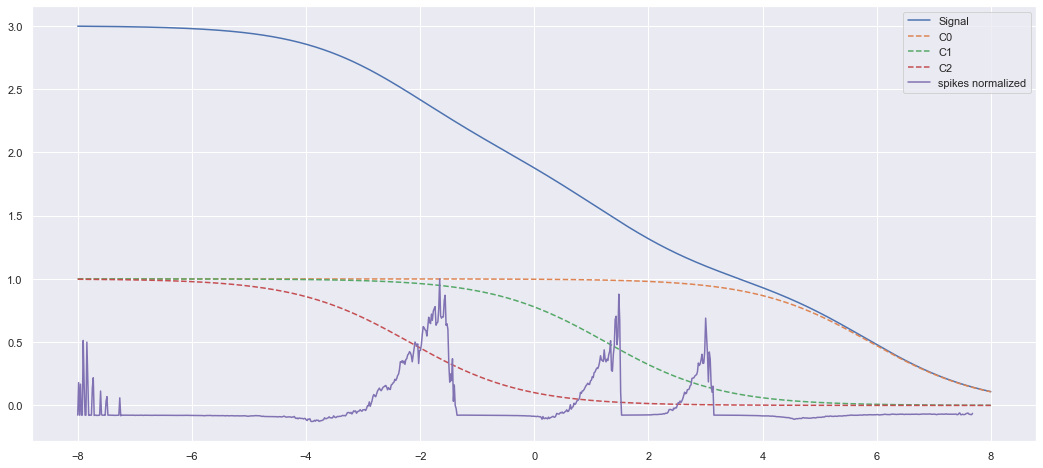

In [57]:

N = 1000
noise = 0.000001
x = np.linspace(-8,8,N)
num_components = 3
sig, basis = build_signal_grid(x, num_components, a=[1,1], lam=[1,1], noise=noise, return_basis=True, center=False)

window = 20
dim = 5
y = stride_eig(sig, window, dim)

plt.plot(x, sig, label='Signal');
[plt.plot(x, c, '--', label=f'C{i}') for i,c in enumerate(basis)]
# plt.plot(x[:N-window], y, label='spikes');
plt.plot(x[:N-window], normalize(y), label='spikes normalized');
plt.legend()
plt.show()

# plot eigne vectors over time


In [89]:
resPH, stimPH = read_lmc('PHOTO');
res3, stim3 = read_lmc('LMC-BG3');

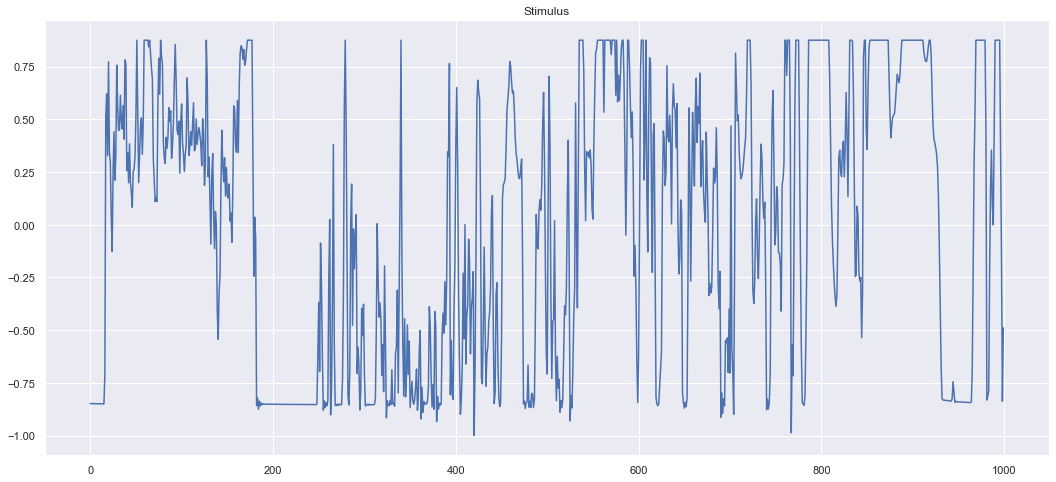

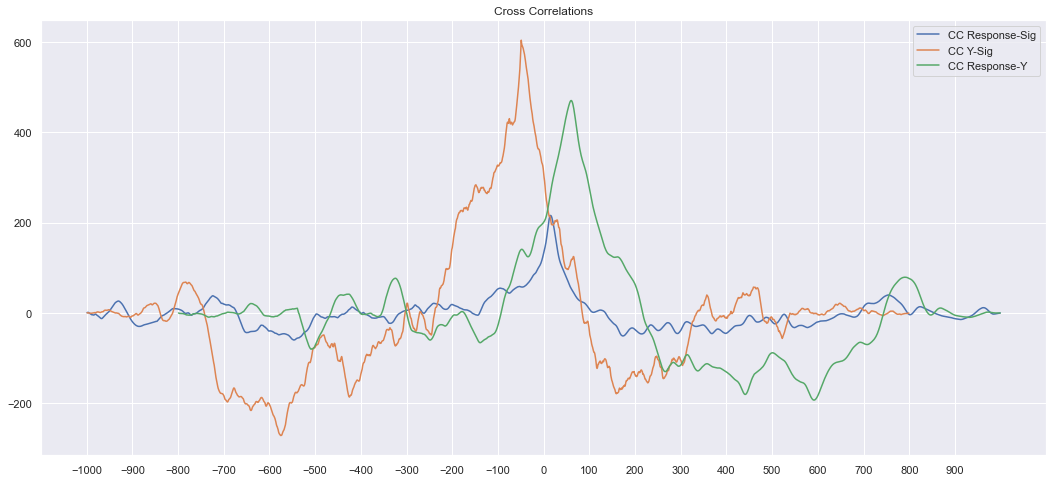

60


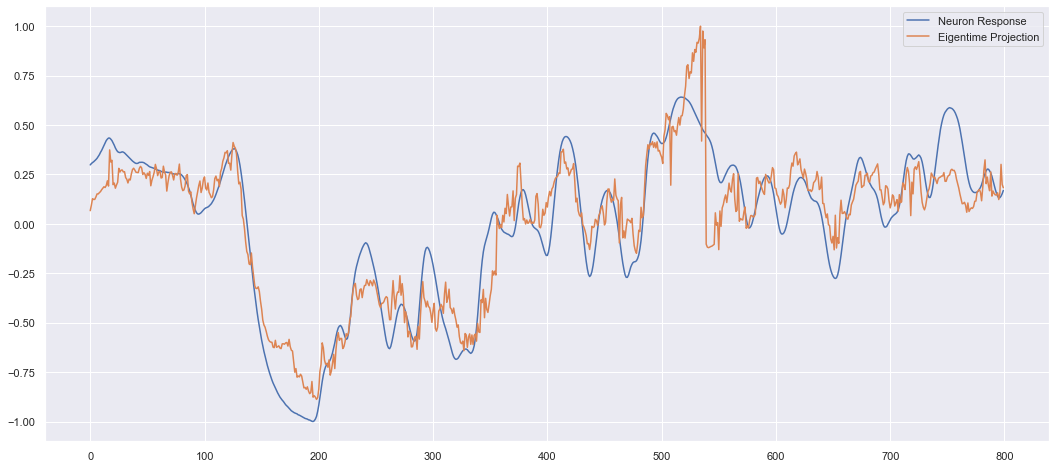

In [99]:

sig = np.mean(stimPH, axis=0)
res = np.mean(resPH, axis=0)
# i = 10
# sig = stimPH[i]
# res = resPH[i]
down = 10
sig = normalize(sig[::down])
res = normalize(res[::down])


plt.plot(sig); plt.title("Stimulus"); plt.show()

window = 200
dim = 50
y, eigs = stride_eig(sig, window, dim, shift=1, stride=1, return_eigs=True)

lags, corr = cross_corr(res, sig)
plt.plot(lags, corr, label='CC Response-Sig');
lags, corr = cross_corr(y, sig)
plt.plot(lags, corr, label='CC Y-Sig');
lags, corr = cross_corr(res, y)
plt.plot(lags, corr, label='CC Response-Y');
plt.title("Cross Correlations")
plt.xticks(np.arange(-1000,1000,100)); plt.legend(); plt.show();
max_corr_index = lags[np.argmax(corr)]
print(max_corr_index)
res = normalize(res[max_corr_index:-window+max_corr_index])
y = normalize(y)
plt.plot(res, label="Neuron Response")
plt.plot(y, label="Eigentime Projection")
plt.legend()
plt.show()



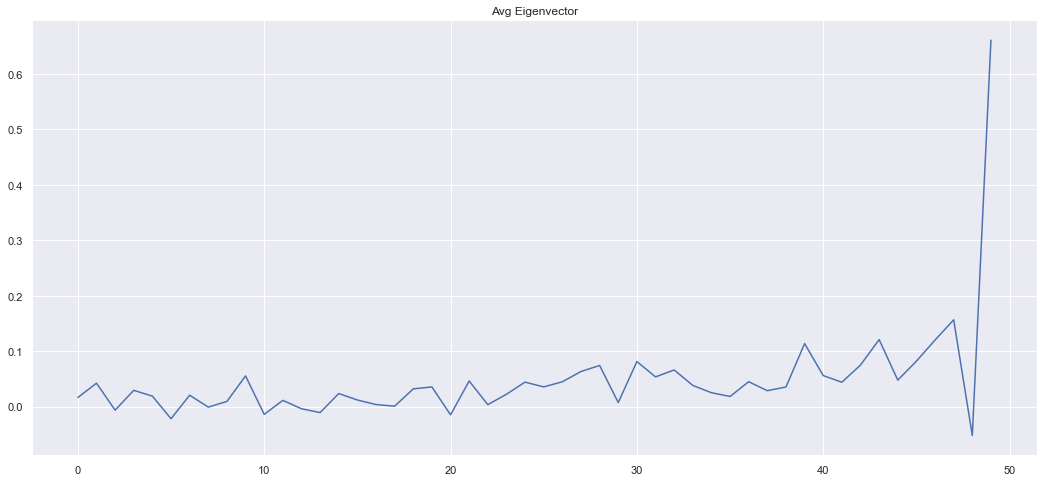

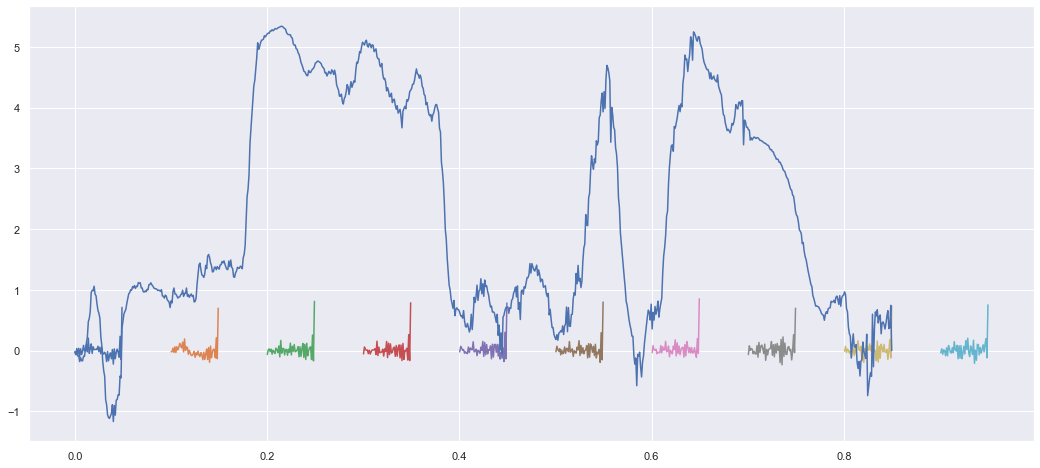

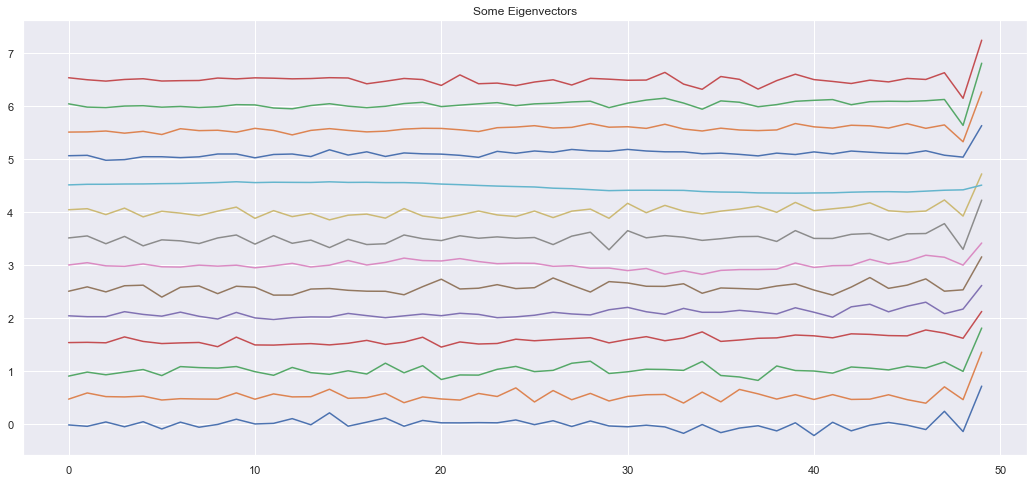

In [101]:
plt.plot(np.mean(eigs, axis=0));
plt.title("Avg Eigenvector")
plt.show()

x = np.linspace(0,1,N)
avg_e = np.zeros(N-window+dim)
sub =10
for i,e in enumerate(eigs):
    if i % sub == 0 and i*sub+dim <N:
        plt.plot(x[i*sub:i*sub+dim],e)
    avg_e[i:i+dim] += e
plt.plot(x[:len(avg_e)], avg_e);
plt.show()

num = 60
[plt.plot(e+i/2) for i,e in enumerate(eigs[::num]) ]
plt.title(f"Some Eigenvectors")
plt.show()